In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Make numpy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

In [2]:
import tensorflow as tf
# import tf-nightly-gpu as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
# tf.debugging.set_log_device_placement(True)
print(tf.__version__)

2.3.1


In [3]:
tf.test.is_built_with_cuda()
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [4]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
tf.config.experimental.list_physical_devices('GPU')

Num GPUs Available:  1


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
TRAIN_COUNT = 100000

In [6]:
# data = pd.read_excel('Simulation.xlsx')
data = pd.read_excel('data.xlsx')

In [7]:
train_dataset = data.sample(frac=0.8, random_state=0)
test_dataset = data.drop(train_dataset.index)

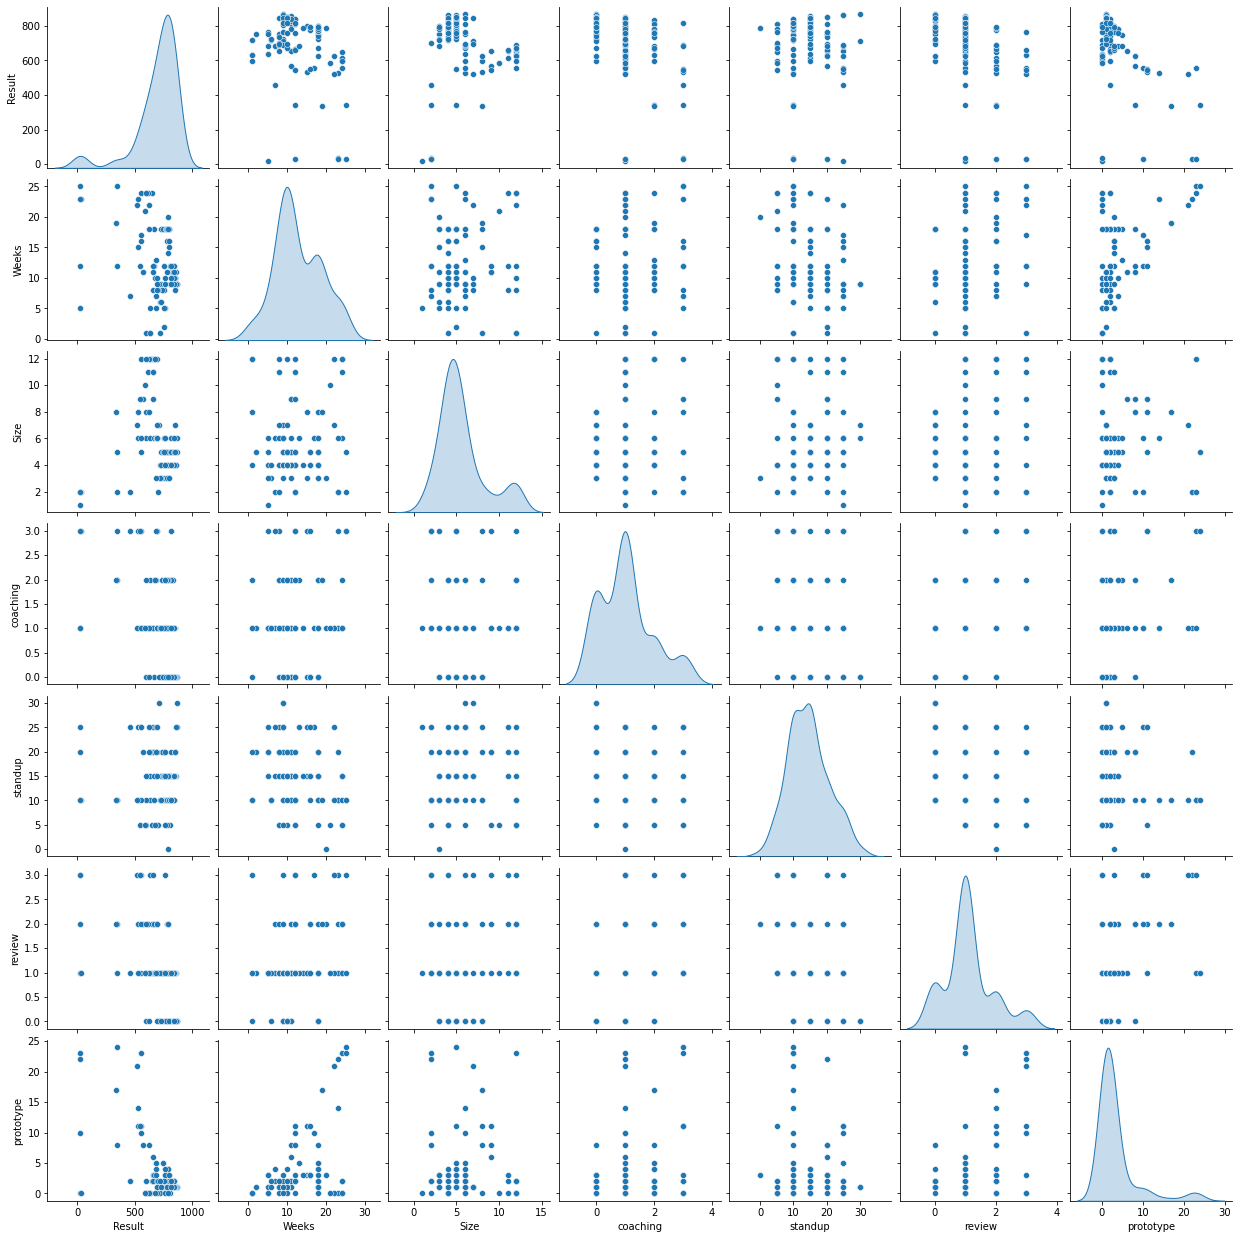

In [8]:
sns.pairplot(train_dataset[['Result', 'Weeks', 'Size', 'coaching', 'standup', 'review','prototype']], diag_kind='kde')

In [9]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('Result')
test_labels = test_features.pop('Result')

In [10]:
train_dataset.describe().transpose()[['mean', 'std']]

,mean,std
Weeks,12.819820,5.865459
Size,5.558559,2.685600
skill 1,0.243243,0.430987
skill 2,0.171171,0.378367
skill 3,0.288288,0.455020
skill 4,0.297297,0.459141
coaching,1.036036,0.893694
standup,14.459459,6.043454
review,1.108108,0.778709
overtime 1,0.180180,0.386080


In [11]:
normalizer = preprocessing.Normalization()
normalizer.adapt(np.array(train_features))
print(normalizer.mean.numpy())

[12.82   5.559  0.243  0.171  0.288  0.297  1.036 14.459  1.108  0.18
  0.441  0.378  3.378]


In [12]:
first = np.array(train_features[:1])

with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', normalizer(first).numpy())

First example: [[18  3  0  0  0  1  0 10  1  0  0  1  1]]

Normalized: [[ 0.89 -0.96 -0.57 -0.45 -0.64  1.54 -1.16 -0.74 -0.14 -0.47 -0.89  1.28
  -0.46]]


In [13]:
Size = np.array(train_features['Size'])

Size_normalizer = preprocessing.Normalization(input_shape=[1,])
Size_normalizer.adapt(Size)

In [14]:
Size_model = tf.keras.Sequential([
    Size_normalizer,
    layers.Dense(units=16)
])

Size_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_1 (Normalizati (None, 1)                 3         
_________________________________________________________________
dense (Dense)                (None, 16)                32        
Total params: 35
Trainable params: 32
Non-trainable params: 3
_________________________________________________________________


In [15]:
Size_model.predict(Size[:10])

array([[-0.345, -0.392, -0.27 ,  0.217,  0.552,  0.279,  0.18 ,  0.048,
         0.404, -0.217, -0.241,  0.515, -0.535,  0.187, -0.338, -0.316],
       [-0.615, -0.699, -0.48 ,  0.387,  0.984,  0.497,  0.321,  0.086,
         0.72 , -0.386, -0.43 ,  0.917, -0.953,  0.332, -0.602, -0.563],
       [-0.075, -0.086, -0.059,  0.047,  0.121,  0.061,  0.039,  0.011,
         0.088, -0.047, -0.053,  0.112, -0.117,  0.041, -0.074, -0.069],
       [-0.075, -0.086, -0.059,  0.047,  0.121,  0.061,  0.039,  0.011,
         0.088, -0.047, -0.053,  0.112, -0.117,  0.041, -0.074, -0.069],
       [-0.345, -0.392, -0.27 ,  0.217,  0.552,  0.279,  0.18 ,  0.048,
         0.404, -0.217, -0.241,  0.515, -0.535,  0.187, -0.338, -0.316],
       [ 0.06 ,  0.068,  0.047, -0.037, -0.095, -0.048, -0.031, -0.008,
        -0.07 ,  0.037,  0.042, -0.089,  0.092, -0.032,  0.058,  0.055],
       [ 0.06 ,  0.068,  0.047, -0.037, -0.095, -0.048, -0.031, -0.008,
        -0.07 ,  0.037,  0.042, -0.089,  0.092, -0.032,  0

In [16]:
Size_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    # optimizer=tf.optimizers.Adam(learning_rate=0),
    loss='mean_absolute_error')

In [17]:
class Print(keras.callbacks.Callback): 
    def on_epoch_end(self, epoch, logs): 
        print (str(epoch)+' / '+str(TRAIN_COUNT), end="\r")

In [18]:
%%time
history = Size_model.fit(
    train_features['Size'], train_labels,
    epochs=TRAIN_COUNT,
    # epochs=1000,
    verbose=0,
    # Calculate validation results on 20% of the training data
    validation_split = 0.2,
    callbacks=[Print()]
    )

Wall time: 35min 57s


In [19]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,val_loss,epoch
99995,97.546906,119.360847,99995
99996,97.542717,119.366463,99996
99997,97.542915,119.364449,99997
99998,97.541962,119.366127,99998
99999,97.544312,119.369118,99999


In [20]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 1000])
  plt.xlabel('Epoch')
  plt.ylabel('Error [Result]')
  plt.legend()
  plt.grid(True)

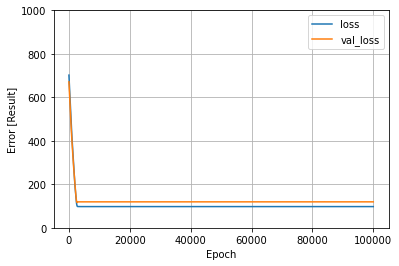

In [21]:
plot_loss(history)

In [22]:
test_results = {}
test_results['Size_model'] = Size_model.evaluate(
    test_features['Size'],
    test_labels, verbose=0)

In [23]:
x = tf.linspace(0.0, 12, 13)
y = Size_model.predict(x)

In [24]:
def plot_Size(x, y):
  plt.scatter(train_features['Size'], train_labels, label='Data')
  plt.plot(x, y, color='k', label='Predictions')
  plt.xlabel('Size')
  plt.ylabel('Result')
  plt.legend()

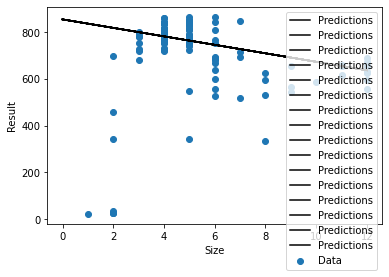

In [25]:
plot_Size(x,y)

In [26]:
linear_model = tf.keras.Sequential([
    normalizer,
    layers.Dense(units=1)
])

In [27]:
linear_model.predict(train_features[:10])

array([[ 0.022],
       [-1.846],
       [ 0.17 ],
       [-0.277],
       [ 0.62 ],
       [ 0.669],
       [ 0.132],
       [ 2.52 ],
       [-0.874],
       [-0.58 ]], dtype=float32)

In [28]:
linear_model.layers[1].kernel

<tf.Variable 'dense_1/kernel:0' shape=(13, 1) dtype=float32, numpy=
array([[ 0.47 ],
       [ 0.451],
       [-0.041],
       [ 0.45 ],
       [-0.072],
       [ 0.086],
       [-0.192],
       [-0.41 ],
       [-0.334],
       [-0.101],
       [ 0.506],
       [-0.052],
       [ 0.139]], dtype=float32)>

In [29]:
linear_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

In [30]:
%%time
history = linear_model.fit(
    train_features, train_labels, 
    epochs=TRAIN_COUNT,
    # suppress logging
    verbose=0,
    # Calculate validation results on 20% of the training data
    validation_split = 0.2, 
    callbacks=[Print()]
    )

Wall time: 38min 26s


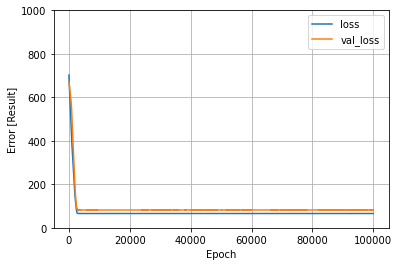

In [31]:
plot_loss(history)

In [32]:

test_results['linear_model'] = linear_model.evaluate(
    test_features, test_labels, verbose=0)

In [33]:
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
      layers.Dense(128, activation='relu'),
      layers.Dense(256, activation='relu'),
      layers.Dense(512, activation='relu'),
      layers.Dense(1024, activation='relu'),
      layers.Dense(2048, activation='relu'),
      layers.Dense(4096, activation='relu'),
      layers.Dense(2048, activation='relu'),
      layers.Dense(1024, activation='relu'),
      layers.Dense(512, activation='relu'),
      layers.Dense(256, activation='relu'),
      layers.Dense(128, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
                # optimizer=tf.keras.optimizers.Adam(0.00001))
  return model

In [34]:
dnn_Size_model = build_and_compile_model(Size_normalizer)
dnn_Size_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_1 (Normalizati (None, 1)                 3         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                128       
_________________________________________________________________
dense_3 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_4 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_5 (Dense)              (None, 512)               131584    
_________________________________________________________________
dense_6 (Dense)              (None, 1024)              525312    
_________________________________________________________________
dense_7 (Dense)              (None, 2048)             

In [35]:
%%time
history = dnn_Size_model.fit(
    train_features['Size'], train_labels,
    validation_split=0.2,
    # validation_split=0,
    verbose=0, epochs=TRAIN_COUNT, 
    callbacks=[Print()]
    )

Wall time: 56min 17s


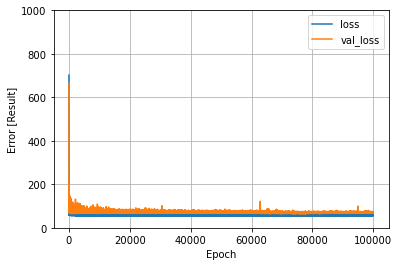

In [36]:
plot_loss(history)

In [37]:
x = tf.linspace(0.0, 12, 13)
y = dnn_Size_model.predict(x)

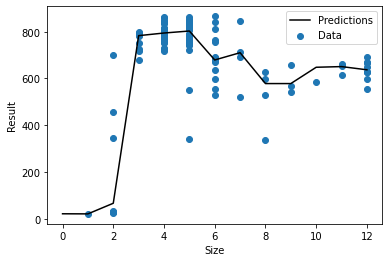

In [38]:
plot_Size(x, y)

In [39]:
test_results['dnn_Size_model'] = dnn_Size_model.evaluate(
    test_features['Size'], test_labels,
    verbose=0)

In [40]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 13)                27        
_________________________________________________________________
dense_16 (Dense)             (None, 64)                896       
_________________________________________________________________
dense_17 (Dense)             (None, 128)               8320      
_________________________________________________________________
dense_18 (Dense)             (None, 256)               33024     
_________________________________________________________________
dense_19 (Dense)             (None, 512)               131584    
_________________________________________________________________
dense_20 (Dense)             (None, 1024)              525312    
_________________________________________________________________
dense_21 (Dense)             (None, 2048)             

In [41]:
%%time
history = dnn_model.fit(
    train_features, train_labels,
    validation_split=0.2,
    verbose=0, epochs=TRAIN_COUNT, 
    callbacks=[Print()]
    )

Wall time: 57min


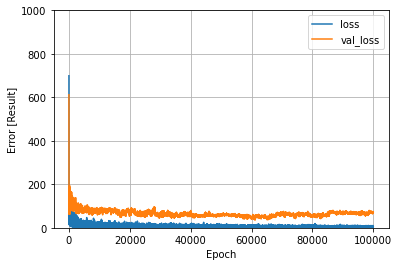

In [42]:
plot_loss(history)

In [43]:
test_results['dnn_model'] = dnn_model.evaluate(test_features, test_labels, verbose=0)

In [44]:
pd.DataFrame(test_results, index=['Mean absolute error [Result]']).T

,Mean absolute error [Result]
Size_model,187.078644
linear_model,121.059731
dnn_Size_model,109.445946
dnn_model,134.071579


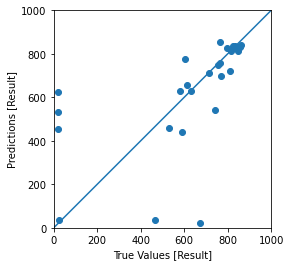

In [45]:
test_predictions = dnn_model.predict(test_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [Result]')
plt.ylabel('Predictions [Result]')
lims = [0, 1000]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

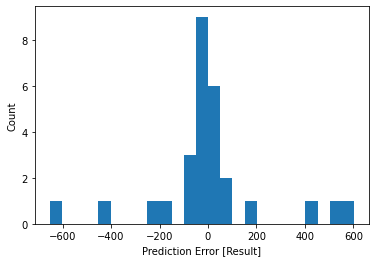

In [46]:
error = test_predictions - test_labels
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [Result]')
_ = plt.ylabel('Count')

In [47]:
dnn_model.save('dnn_model')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: dnn_model\assets
